In [1]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.datasets import MultiTemporalCropClassification
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/dccstor/geofm-finetuning/pedrohc/miniforge3/envs/benchmark/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


wxc_downscaling not installed
wxc_downscaling not installed


In [ ]:
# If you dont have the dataset yet, download it at https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification
# from huggingface_hub import snapshot_download

# repo_id = <repo_id>
# local_path = snapshot_download(repo_id=repo_id)

## MultiTemporalCrop Example

In [2]:
DATASET_PATH = os.path.join('dataset_dir', 'hls_cdl_reclassed')

In [3]:
# those are the recommended transforms for this task
transforms = [
    terratorch.datasets.transforms.FlattenTemporalIntoChannels(),
    albumentations.Flip(),
    albumentations.pytorch.transforms.ToTensorV2(),
    terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
]

In [4]:
# this datamodule allows access to the dataset in its various splits.
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    expand_temporal_dimension=True,
)

In [5]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [6]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3083

In [7]:
# checking datasets available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [8]:
# checking datasets classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

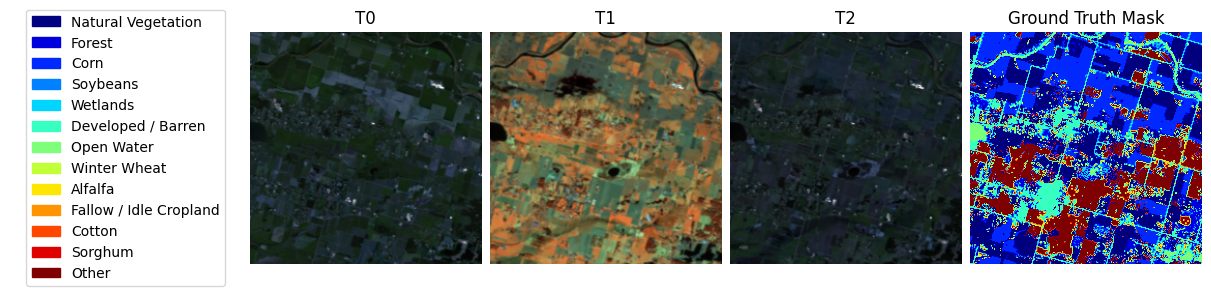

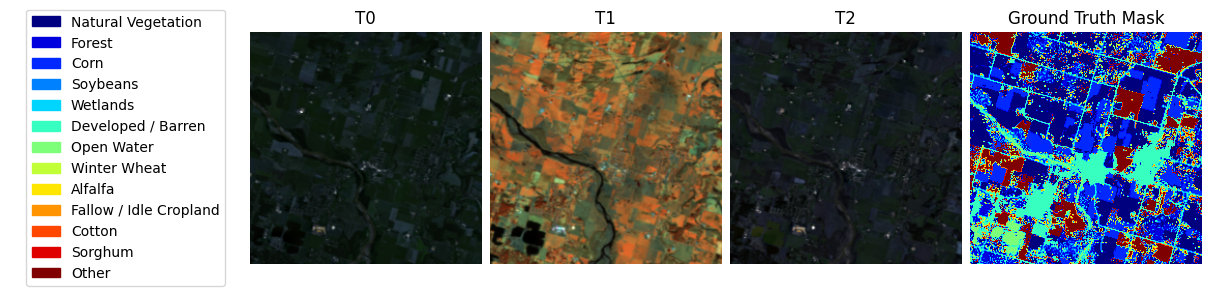

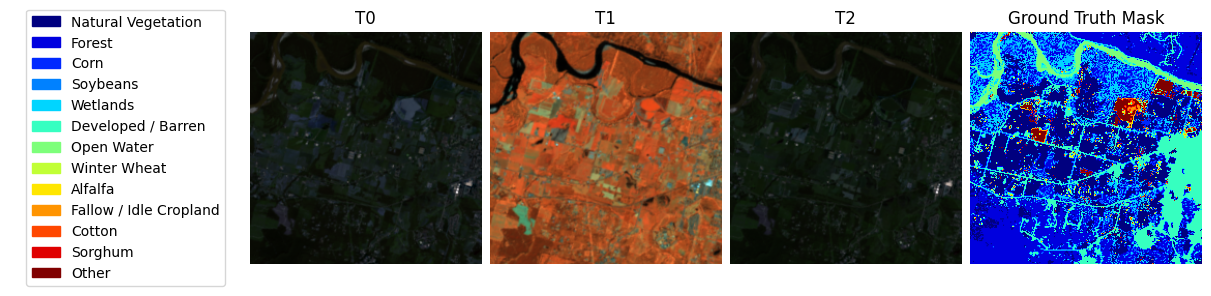

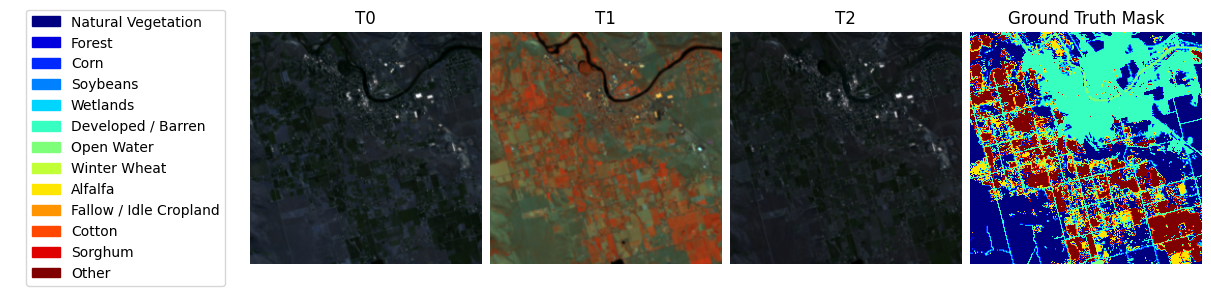

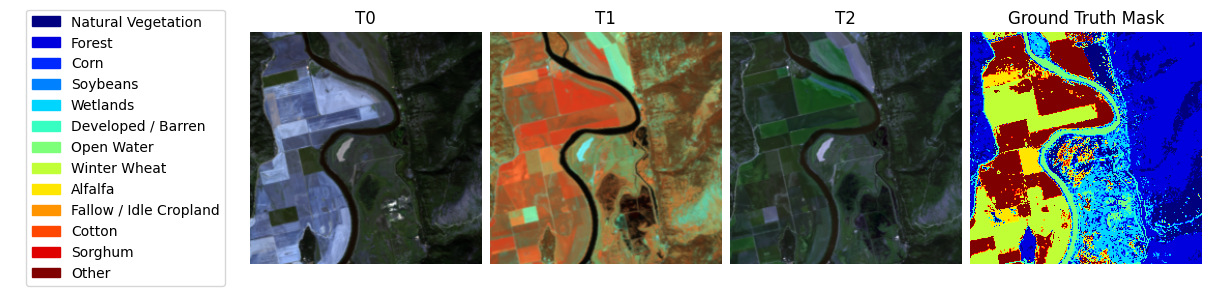

In [9]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [10]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

771

In [11]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

771

In [12]:
# Logger
logger = TensorBoardLogger(
    save_dir="output",
    name="tutorial"
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",
    mode="min",
    dirpath="checkpoints",
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    num_nodes=1,
    logger = logger,
    max_epochs=30,
    check_val_every_n_epoch=2,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    default_root_dir="root_dir",
)

# DataModule
data_module = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    reduce_zero_label=True,
    expand_temporal_dimension=True,
    use_metadata=True, # Multicropclassification dataset has metadata for location and time
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300_tl", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "backbone_features_only": True,
        "backbone_coords_encoding": ["time", "location"],
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 3,
        "backbone_coords_encoding": ["time", "location"],
        "num_classes": 13,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            }
        ]

    },
    plot_on_val=False,
    class_weights=[0.386375, 0.661126, 0.548184, 0.640482, 0.876862, 0.925186, 3.249462, 1.542289, 2.175141, 2.272419, 3.062762, 3.626097, 1.198702],
    loss="ce",
    lr=2.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

# Training
trainer.fit(model, datamodule=data_module)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (('ibm-nasa-geospatial/Prithvi-EO-2.0-300M-TL', 'Prithvi_EO_V2_300M_TL.pt'))
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | PixelWiseModel   | 364 M 
1 | criterion     | CrossEntropyLoss | 0     
2 | train_metrics | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [13]:
trainer.test(model, datamodule=data_module, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /u/pedrohc/notebooks/checkpoints/best-checkpoint-epoch=01-val_loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /u/pedrohc/notebooks/checkpoints/best-checkpoint-epoch=01-val_loss=0.00.ckpt
/dccstor/geofm-finetuning/pedrohc/miniforge3/envs/benchmark/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expl

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.3131881654262543          │
│      test/Multiclass_F1_Score       │         0.3131881654262543          │
│    test/Multiclass_Jaccard_Index    │         0.22025784850120544         │
│ test/Multiclass_Jaccard_Index_Micro │         0.1856686919927597          │
│              test/loss              │         1.7090516090393066          │
│      test/multiclassaccuracy_0      │         0.27724510431289673         │
│      test/multiclassaccuracy_1      │         0.12029321491718292         │
│     test/multiclassaccuracy_10      │         0.7602322697639465          │
│     test/multiclassaccuracy_11      │         0.7889718413352966          │
│     test/multiclassaccuracy_12      │         0.19718962907791138         │
│      test/multiclassaccuracy_2      │         0.2241484820842743          │
│      test/multiclassaccuracy_3      │         0.05207305774092674         │
│      test/multiclassaccuracy_4      │         0.7097654938697815          │
│      test/multiclassaccuracy_5      │         0.24678297340869904         │
│      test/multiclassaccuracy_6      │         0.8335617780685425          │
│      test/multiclassaccuracy_7      │         0.4594081938266754          │
│      test/multiclassaccuracy_8      │         0.3914618194103241          │
│      test/multiclassaccuracy_9      │         0.4970974624156952          │
│    test/multiclassjaccardindex_0    │         0.23770883679389954         │
│    test/multiclassjaccardindex_1    │         0.1121317446231842          │
│   test/multiclassjaccardindex_10    │         0.05845671519637108         │
│   test/multiclassjaccardindex_11    │         0.15859048068523407         │
│   test/multiclassjaccardindex_12    │         0.1535799503326416          │
│    test/multiclassjaccardindex_2    │         0.18989013135433197         │
│    test/multiclassjaccardindex_3    │        0.050137486308813095         │
│    test/multiclassjaccardindex_4    │         0.3142148554325104          │
│    test/multiclassjaccardindex_5    │         0.2131134420633316          │
│    test/multiclassjaccardindex_6    │         0.5811507701873779          │
│    test/multiclassjaccardindex_7    │         0.3439602255821228          │
│    test/multiclassjaccardindex_8    │         0.21369285881519318         │
│    test/multiclassjaccardindex_9    │         0.2367246299982071          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 1.7090516090393066,
  'test/Multiclass_Accuracy': 0.3131881654262543,
  'test/multiclassaccuracy_0': 0.27724510431289673,
  'test/multiclassaccuracy_1': 0.12029321491718292,
  'test/multiclassaccuracy_2': 0.2241484820842743,
  'test/multiclassaccuracy_3': 0.05207305774092674,
  'test/multiclassaccuracy_4': 0.7097654938697815,
  'test/multiclassaccuracy_5': 0.24678297340869904,
  'test/multiclassaccuracy_6': 0.8335617780685425,
  'test/multiclassaccuracy_7': 0.4594081938266754,
  'test/multiclassaccuracy_8': 0.3914618194103241,
  'test/multiclassaccuracy_9': 0.4970974624156952,
  'test/multiclassaccuracy_10': 0.7602322697639465,
  'test/multiclassaccuracy_11': 0.7889718413352966,
  'test/multiclassaccuracy_12': 0.19718962907791138,
  'test/Multiclass_F1_Score': 0.3131881654262543,
  'test/Multiclass_Jaccard_Index': 0.22025784850120544,
  'test/multiclassjaccardindex_0': 0.23770883679389954,
  'test/multiclassjaccardindex_1': 0.1121317446231842,
  'test/multiclassjaccardin

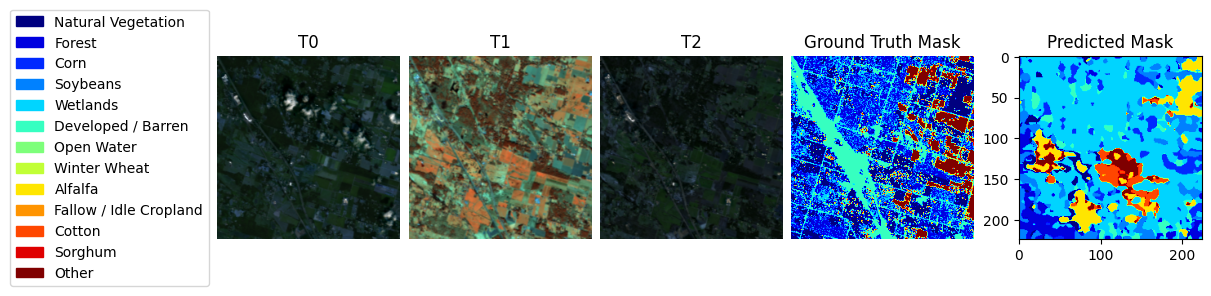

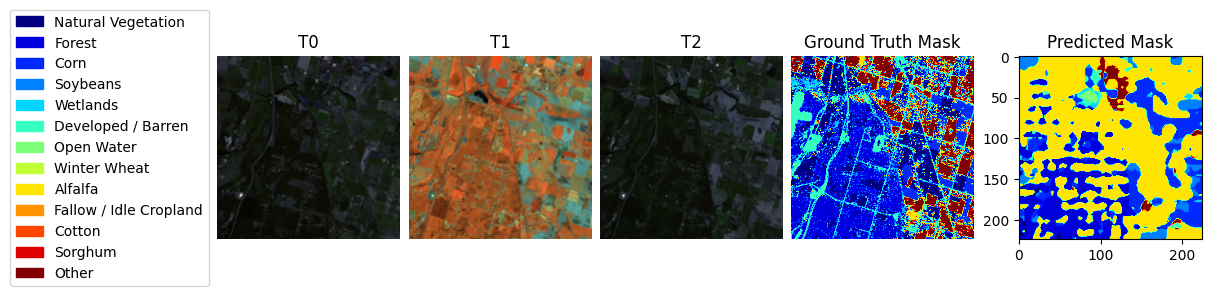

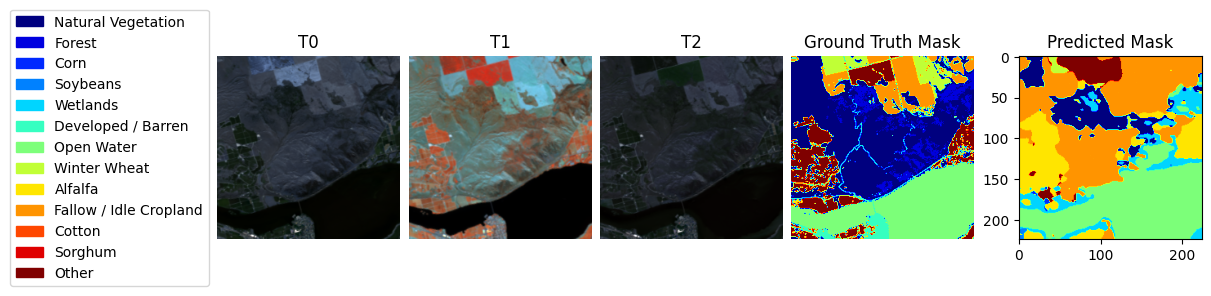

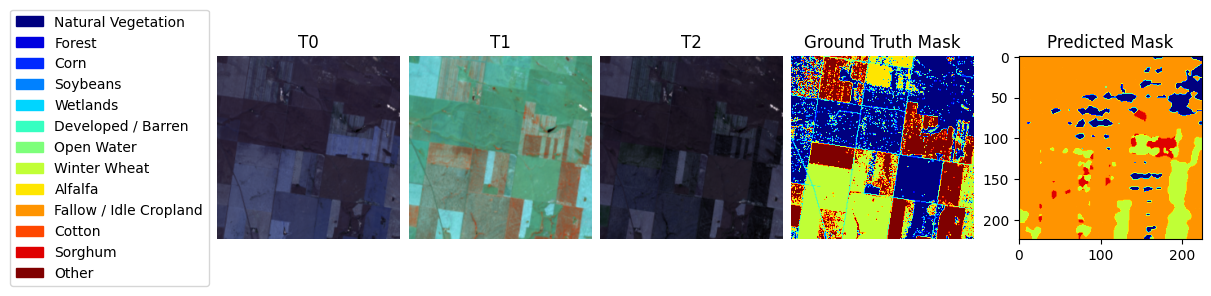

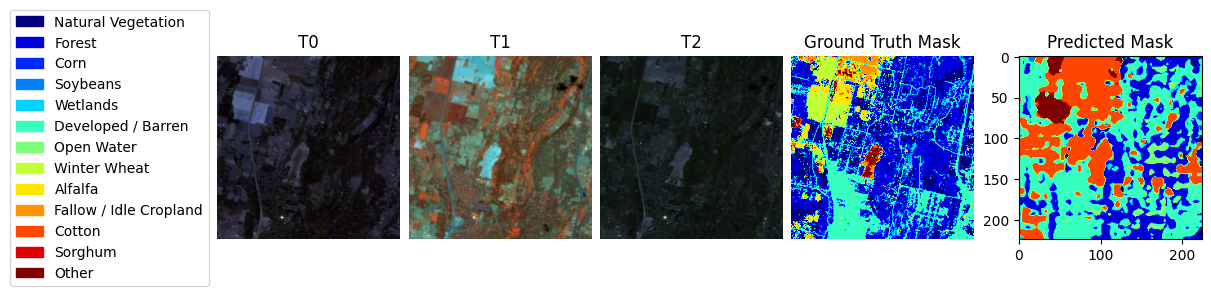

In [14]:
# now we can use the model for predictions and ploting!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].numpy()
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)